In [ ]:
#### Either store centroids while making grid or calculate from offset and image number
#### Setting grayscale background threshold : for original image or cropped image? try both
#### ==> Using threshold for the cropped image works well 
#### Also, test the detect red function on the transformed images/grids: IMPORTANT: Can marked full solders be detected ?? ://

In [29]:
import sys
sys.executable

'/home/dnyanadajoshi/anaconda3/envs/project/bin/python'

In [1]:
import cv2
from math import gcd
import subprocess
import matplotlib.pyplot as plt
import os, shutil, glob
#from skimage import measure
import numpy as np
import csv
import itertools
import random
#np.set_printoptions(threshold=sys.maxsize)

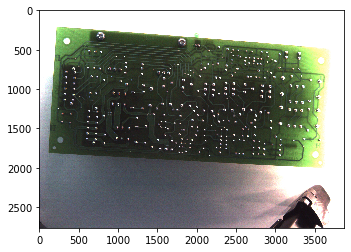

In [2]:
ext = '.bmp'

#******Single PCB Image test*****
#data_path = '/Users/dnyanadajoshi/Dropbox/data/'
#infile = 'DSC_0630.jpg'
#marked = 'DSC_0630_an.JPG'
#file_original = 'DSC_0630_transform1.JPG'
#file_marked = 'DSC_0630_transform2-ppt.JPG'
#infile_cropped = 'DSC_0630_noBg.JPG'
#*****-----------------*****

#FOR ACTUAL DATASET
data_path = '/home/dnyanadajoshi/data/0719/'
data_parent = '/home/dnyanadajoshi/data/'
subdir = 'OK/'
subdir_cropped = 'OK_cropped/'
original_name = 'ok_6'+ext
marked_name = 'NG_1_checkmark'+ext
file_original = original_name[:-len(ext)] + "_cropped"+ext
file_marked = marked_name[:-len(ext)] + "_cropped"+ext
original = cv2.imread(data_path+subdir+original_name)
plt.imshow(original)
plt.show()

In [829]:
#******Single PCB Image test*****
#crop_path_original = data_path+file_original[:-len(ext)]+'/'
#crop_path_marked = data_path+file_marked[:-len(ext)]+'/'
#prefix_original = crop_path_original+file_original[:-(len(ext))]+"_offset"
#prefix_marked = crop_path_marked+file_marked[:-(len(ext))]+"_offset"
#NAMING FORMAT: prefix+offset+'_'+gridcount+ext
test = [254,284,274,293,322,429,504]
#*****-----------------*****

#FOR ACTUAL DATASET
crop_path_original = data_path+subdir_cropped+original_name[:-len(ext)]+'/'
crop_path_marked = data_path+subdir_cropped+marked_name[:-len(ext)]+'/'
prefix_original = crop_path_original+original_name[:-len(ext)]+"_offset"
prefix_marked = crop_path_marked+marked_name[:-len(ext)]+"_offset"

In [22]:
def read_RGB(file):
    return cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)

In [23]:
#******Single PCB Image test*****
#image = cv2.imread(data_path+infile)
#image_an = cv2.imread(data_path+marked)
#im_original = cv2.imread(data_path+file_original)
#im_marked = cv2.imread(data_path+file_marked)
#*****-----------------*****
#FOR ACTUAL DATASET 
original = cv2.imread(data_path+subdir+original_name)
marked = cv2.imread(data_path+subdir+marked_name)
#print(marked)

In [4]:
#Input : grayscale image
def get_threshold(gray):
    (thresh, output) = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return thresh

In [5]:
#Ref  https://henrydangprg.com/2016/06/26/color-detection-in-python-with-opencv/
def detect_color(values, im, delta=10, rgb_select = False, min_sat=100, min_value=100):
    color = np.uint8([[[values[0], values[1], values[2]]]])
    flag = cv2.COLOR_BGR2HSV
    if rgb_select:
            flag = cv2.COLOR_RGB2HSV_FULL
    hsv_color = cv2.cvtColor(color, flag)
    hue = hsv_color[0][0][0]
    #print("Hue: ",hue)
    lower = np.array([(hue-delta), min_sat, min_value])
    upper = np.array([(hue+delta), 255, 255])
    return cv2.inRange(im, lower, upper)

from skimage import feature
edged = feature.canny(gray, sigma=3)
plt.imshow(edged, cmap='gray')
plt.show()

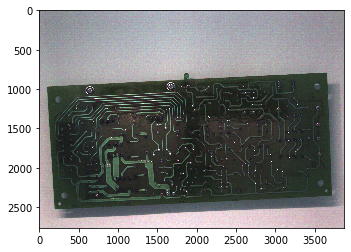

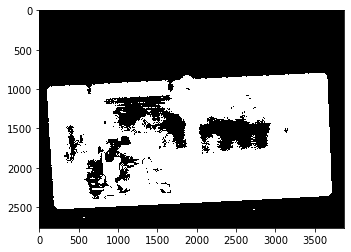

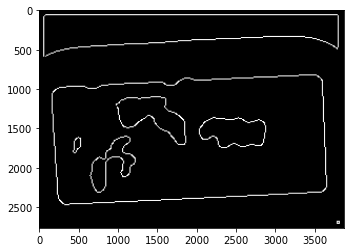

(2764, 3872)
HULL :
[[ 247.  968.]
 [ 234. 2401.]
 [3611.  878.]
 [3597. 2322.]]


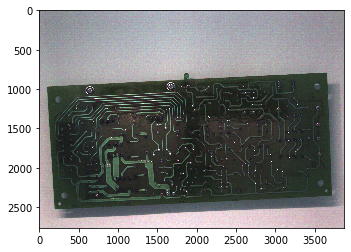

In [708]:
#Ref : https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_shi_tomasi/py_shi_tomasi.html
#Good features to detect
#gets top N strongest corners in the image 

def corner_detection(input_image):
        
    gray_ = cv2.cvtColor(input_image,cv2.COLOR_BGR2GRAY)
    bw_ = cv2.threshold(gray_, get_threshold(gray_)+40, 255, cv2.THRESH_BINARY)[1]
    corners = cv2.goodFeaturesToTrack(bw_,25,0.01,200)
    corners = np.int0(corners)

    for i in corners:
        x,y = i.ravel()
        cv2.circle(input_image,(x,y),10,255,-1)

    plt.imshow(input_image)
    plt.show()

def resize(img, height=170):
    """ Resize image to given height """
    rat = height / img.shape[0]
    return cv2.resize(img, (int(rat * img.shape[1]), height))

#Detecting corner points by finding contours
#Ref (1): https://www.pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/
#Ref (2): https://bretahajek.com/2017/01/scanning-documents-photos-opencv/
#Algorithm: Use edge detection, get an edged image, find contours, sort by area, approximate the contours 
#and if the approx curve is a quadrilateral then store then 4 points

#Returns points in order of: TOP_LEFT, TOP_RIGHT, BT_LEFT, BT_RIGHT
#Original: resize, bilateral_filter, adaptive_threshold, median_blur, edges canny()
def find_contours(input_image):
   
    
    bgr_green = [35,46,32]
    mask_green = detect_color(bgr_green, cv2.cvtColor(cv2.medianBlur(input_image,95), cv2.COLOR_BGR2HSV), delta=35, min_sat=10, min_value=10)
    #blur_mask = cv2.bilateralFilter(mask_green, 9,105, 105)
    plt.imshow(mask_green, cmap="gray")
    plt.show()
    
    gray_ = cv2.cvtColor(resize(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)), cv2.COLOR_BGR2GRAY)
    
    gray_ = cv2.medianBlur(resize(mask_green, height=200),11)
    
    blur = cv2.bilateralFilter(gray_, 9, 75, 75)
    
    #LOGS: 06/25/2019, old threshold valus were 115,4
    img = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)
    
    #LOGS: 06/25/2019, old median value was 11
    #img = cv2.medianBlur(img, 11)
    
    
    img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    edges = cv2.Canny(img, 200, 250)
    #edges = cv2.Canny()
    edge_restore = cv2.resize(edges, (input_image.shape[1], input_image.shape[0]))
    
    plt.imshow(edge_restore, cmap = 'gray')
    plt.show()
    print(edge_restore.shape)
    
    contours = cv2.findContours(edge_restore.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[1]
    #Above function returns img, contours, hierarchy(?) => We pick only contours
    #contours is a list of numpy array of coordinates
    
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:3] #Pick only the top 3 contours with max area
    for c in contours[0:]:
        
        perimeter = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.06*perimeter, True)
        #TODO: increase the second argument of above function by 0.1% until you get 4 points (TODO)
        #06/26/19: Changed perimeter weight. old was 0.06

        if len(approx) == 4:
            
            
            #TODO: make function for ordering
            
            approx = approx.reshape(4,2)
            
            #Lex sort : http://www.codehamster.com/2015/03/16/sort-2d-array-in-python/
            ind = np.lexsort((approx[:, 1], approx[:, 0]))
            approx = approx[ind]
     
            #following idea inspired by Ref(2)
            
            points_ = [0,0,0,0]
            #1) When we apply lexsort, we get top points first and then bottom points 
            #2) In order to differenciate between topleft and topright, we do the following
            #3) top left has min difference and top right max max among the top two points
            top = approx[:2]
            topdiff = abs(np.diff(top))
            points_[0] = top[np.argmin(topdiff)]
            points_[1] = top[np.argmax(topdiff)]

            #4) Similarly for Btleft and Btright
            bottom = approx[2:]
            btdiff = abs(np.diff(bottom))
            points_[2] = bottom[np.argmax(btdiff)]
            points_[3] = bottom[np.argmin(btdiff)]
            return np.float32(points_), c

#corner_detection(image)
plt.imshow(original)
plt.show()
points1, cnt = find_contours(original)
hull = cv2.convexHull(cnt,returnPoints=True)
print("HULL :")
#print(hull)

print(points1)
#print(points2)
plt.imshow(original)
plt.show()
#plt.imshow(marked)
#plt.show()

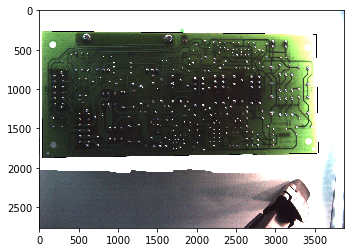

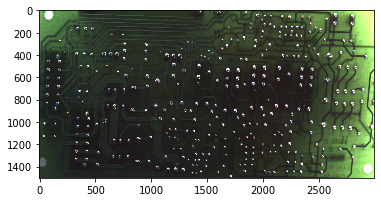

True

In [381]:
#Perspective tranformation trial
#Ref: https://pysource.com/2018/02/14/perspective-transformation-opencv-3-4-with-python-3-tutorial-13/
#print((image.shape))
#src = np.float32(points)
src_original = points1

#IMP: *** MAINTAING FOLLOWING ORDER ***
#TL, TR, BL, BR
dst = np.float32([[0,0], [0, 1500], [3000, 0], [3000, 1500]])

mat_original = cv2.getPerspectiveTransform(src_original,dst)


#Get transformed images for original and marked inputs
tf_original = cv2.warpPerspective(original, mat_original, (3000,1500))


#plt.imshow(image)
plt.show()
plt.imshow(original)
plt.show()
#plt.imshow(transform)
#plt.show()
plt.imshow(tf_original)
plt.show()

cv2.imwrite(data_path+subdir_cropped+file_original, tf_original)




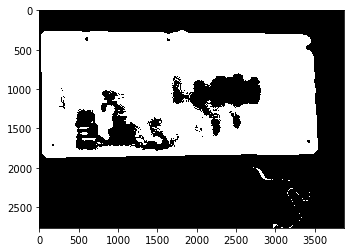

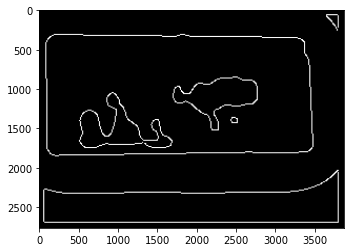

(2764, 3872)


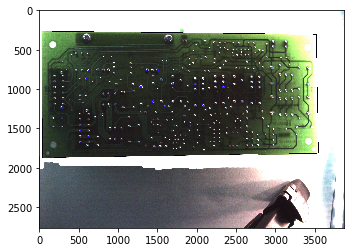

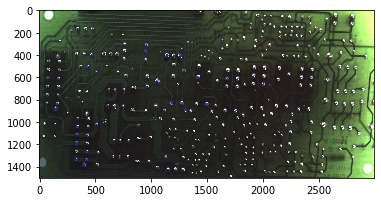

In [382]:
#FOR MARKED
points2, cnt = find_contours(marked)
src_marked = points2
mat_marked = cv2.getPerspectiveTransform(src_marked,dst)
tf_marked = cv2.warpPerspective(marked, mat_marked, (3000,1500))
cv2.imwrite(data_path+subdir_cropped+file_marked, tf_marked)
plt.imshow(marked)
plt.show()
plt.imshow(tf_marked)
plt.show()

#Inverse perspective transform 
#Ref : https://stackoverflow.com/questions/32366786/opencv-homography-matrix-h-and-inverse-h-to-transform-a-point-is-not-getting-exp
def invert_points(x, y, H):
    _, inv = cv2.invert(H)
    tx = H[0,0]*x + H[0,1]*y + H[0,2]
    ty = H[1,0]*x + H[1,1]*y + H[1,2]
    tz = H[2,0]*x + H[2,1]*y + H[2,2]
    ix = int(tx/tx)
    iy = int(ty/tz)
    
    return (ix,iy)

(ix, iy) = invert_points(0, 1700, m1)
print((ix, iy))

#Background removal
#REFERENCE: https://stackoverflow.com/questions/48395434/how-to-crop-or-remove-white-background-from-an-image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

#### (2) Morph-op to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

#### (3) Find the max-area contour
cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
cnt = sorted(cnts, key=cv2.contourArea)[-1]

#### (4) Crop and save it
x,y,w,h = cv2.boundingRect(cnt)
dst = image[y:y+h, x:x+w]
cv2.imwrite(data_path+infile[:-4]+'_noBg.JPG', dst)

# Use transformed images to make and store grids as follows

In [6]:
def make_cb_grids(file_original, crop_height, crop_width, crop_path_original, ismarked=False, file_marked=None, crop_path_marked=None):
    
    tf_original = cv2.imread(file_original)
    if ismarked:
        tf_marked = cv2.imread(file_marked)
    thresh_first = get_threshold(cv2.cvtColor(tf_original, cv2.COLOR_BGR2GRAY))
    print(file_original)


    cropped = tf_original[:crop_height,:crop_width]
    cropped.shape

    #Test
    #cv2.imwrite(data_path+'cropped_0630.JPG',cropped)

    #subprocess.run(["mkdir", data_path+file_original[:-4]])
    #subprocess.run(["mkdir", data_path+file_marked[:-4]])

    #FOR ACTUAL DATASET
    subprocess.run(["rm","-rf", crop_path_original])
    subprocess.run(["mkdir", crop_path_original])
    
    if ismarked:
        subprocess.run(["rm","-rf", crop_path_marked])
        subprocess.run(["mkdir", crop_path_marked])

    offset_list = []
    offset_list_xy = []


    def make_grid(crop_path, infile_, image_, crop_dims, annotated=False):

    
        offset_list_xy = []
        #TODO: MISNOMER ALERT !!! change the name num_squares to grid_size. 
        offset = 0
        crop_height_ = crop_dims[0]
        crop_width_ = crop_dims[1]
        
        #TODO: change?? 
        n_height = image_.shape[0]//crop_height_
        n_width = image_.shape[1]//crop_width_
        
        print("OFFSETS:", offset_list)
        ht = crop_height_//4
        wd = crop_width_//4
        off_ht = ht
        off_wd = wd
        offset_list_xy.append((0,0))
        for i in range(3):
            off_ht  =ht
            for j in range(3):
                off = (off_ht, off_wd)
                offset_list_xy.append(off)
                off_ht += ht
            off_wd += wd

        print("OFFSET XY  ", offset_list_xy)                                                                    

        for o in offset_list_xy:
            grid_count = 0
            for i in range(n_height):
                for j in range(n_width):
                    #cropped = image_[i*num_squares+o[0]:(i+1)*num_squares+o[0], j*num_squares+o[1]:(j+1)*num_squares+o[1]]
                    cropped = image_[i*crop_height_+o[0]:(i+1)*crop_height_+o[0], j*crop_width_+o[1]:(j+1)*crop_width_+o[1]]
                    
                    if cropped.shape == (crop_height_, crop_width_, 3):
                        cv2.imwrite(crop_path+infile_[:-len(ext)]+'_offset'+str(o[0])+'_'+str(o[1])+'_'+str(grid_count)+ext, cropped)
                    grid_count += 1
        #f.close()

    #annotated_list = make_grid(crop_path_test, marked, image_an, (crop_height, crop_width), annotated=True)
    original_name = os.path.basename(file_original.replace("_cropped",""))
    make_grid(crop_path_original, original_name, tf_original, (crop_height, crop_width))
    if ismarked:
        marked_name = os.path.basename(file_marked.replace("_cropped",""))
        make_grid(crop_path_marked, marked_name, tf_marked, (crop_height, crop_width))
    #make_grid(crop_path_original, original_name, tf_original, (crop_height, crop_width))
    #make_grid(crop_path_checked, checked_name, tf_marked, (crop_height, crop_width))

crop_size = 100
ok_files = sorted(glob.glob(data_parent+"????/OK_cropped/ok_*"+ext))
#ok_dirs = sorted(glob.glob(data_parent+"????/OK_cropped/ok_*/"))
for o in range(len(ok_files)):
    make_cb_grids(ok_files[o], crop_size, crop_size, ok_files[o][:-len(ext)]+"_"+str(crop_size)+"/")
    
ng_files = sorted(glob.glob(data_parent+"????/NG_cropped/NG_*[0-9]_cropped"+ext))
#ng_dirs = sorted(glob.glob(data_parent+"????/NG_cropped/NG_*[0-9]/"))
ng_marked = sorted(glob.glob(data_parent+"????/NG_cropped/NG_*[0-9]_checkmark_cropped"+ext))
#ng_marked_dirs = sorted(glob.glob(data_parent+"????/NG_cropped/NG_*[0-9]_checkmark/"))
for o in range(len(ng_files)):
    make_cb_grids(ng_files[o], crop_size, crop_size, ng_files[o][:-len(ext)]+"_"+str(crop_size)+"/", True, ng_marked[o], ng_marked[o][:-len(ext)]+"_"+str(crop_size)+"/")
    

/home/dnyanadajoshi/data/0624/OK_cropped/ok_10_cropped.bmp
OFFSETS: []
OFFSET XY   [(0, 0), (25, 25), (50, 25), (75, 25), (25, 50), (50, 50), (75, 50), (25, 75), (50, 75), (75, 75)]
/home/dnyanadajoshi/data/0624/OK_cropped/ok_11_cropped.bmp
OFFSETS: []
OFFSET XY   [(0, 0), (25, 25), (50, 25), (75, 25), (25, 50), (50, 50), (75, 50), (25, 75), (50, 75), (75, 75)]
/home/dnyanadajoshi/data/0624/OK_cropped/ok_12_cropped.bmp
OFFSETS: []
OFFSET XY   [(0, 0), (25, 25), (50, 25), (75, 25), (25, 50), (50, 50), (75, 50), (25, 75), (50, 75), (75, 75)]
/home/dnyanadajoshi/data/0624/OK_cropped/ok_13_cropped.bmp
OFFSETS: []
OFFSET XY   [(0, 0), (25, 25), (50, 25), (75, 25), (25, 50), (50, 50), (75, 50), (25, 75), (50, 75), (75, 75)]
/home/dnyanadajoshi/data/0624/OK_cropped/ok_14_cropped.bmp
OFFSETS: []
OFFSET XY   [(0, 0), (25, 25), (50, 25), (75, 25), (25, 50), (50, 50), (75, 50), (25, 75), (50, 75), (75, 75)]
/home/dnyanadajoshi/data/0624/OK_cropped/ok_15_cropped.bmp
OFFSETS: []
OFFSET XY   [(0, 0)

/home/dnyanadajoshi/data/0709/OK_cropped/ok_4_cropped.bmp
OFFSETS: []
OFFSET XY   [(0, 0), (25, 25), (50, 25), (75, 25), (25, 50), (50, 50), (75, 50), (25, 75), (50, 75), (75, 75)]
/home/dnyanadajoshi/data/0709/OK_cropped/ok_5_cropped.bmp
OFFSETS: []
OFFSET XY   [(0, 0), (25, 25), (50, 25), (75, 25), (25, 50), (50, 50), (75, 50), (25, 75), (50, 75), (75, 75)]
/home/dnyanadajoshi/data/0709/OK_cropped/ok_6_cropped.bmp
OFFSETS: []
OFFSET XY   [(0, 0), (25, 25), (50, 25), (75, 25), (25, 50), (50, 50), (75, 50), (25, 75), (50, 75), (75, 75)]
/home/dnyanadajoshi/data/0716/OK_cropped/ok_1_cropped.bmp
OFFSETS: []
OFFSET XY   [(0, 0), (25, 25), (50, 25), (75, 25), (25, 50), (50, 50), (75, 50), (25, 75), (50, 75), (75, 75)]
/home/dnyanadajoshi/data/0716/OK_cropped/ok_2_cropped.bmp
OFFSETS: []
OFFSET XY   [(0, 0), (25, 25), (50, 25), (75, 25), (25, 50), (50, 50), (75, 50), (25, 75), (50, 75), (75, 75)]
/home/dnyanadajoshi/data/0716/OK_cropped/ok_3_cropped.bmp
OFFSETS: []
OFFSET XY   [(0, 0), (25,

In [62]:
#name = prefix+'0_'+str(981)
#red = cv2.imread(name+ext)

In [7]:
def remove_noise(img):
    img = 255 - img 
    kernel = np.ones((3,3),np.float32)
    kernel[1][1] = 0
    dst =cv2.filter2D(img,-1,kernel)
    dst = 255 - dst
    return dst

In [8]:
def pixel_intensities(layers):
    
    PI = []
    grid_size = hcf//factor
    for l in range(len(layers)):
        total_pixels = 4*(grid_size-2*l-1)
        total_white = int(layers[l])
        PI.append(total_white/total_pixels)
    return PI

In [13]:
#Scrap vars
name = prefix_marked+'375_279_'+str(10)+ext

NameError: name 'prefix_marked' is not defined

In [9]:
#CODE TO FILTER FULL SOLDERS
#Blob detection
#Reference : https://www.pyimagesearch.com/2016/10/31/detecting-multiple-bright-spots-in-an-image-with-python-and-opencv/
def isMarked(im_):
    bgr_red = [36,28,237]
    red_mask = detect_color(bgr_red, cv2.cvtColor(im_, cv2.COLOR_BGR2HSV), delta=10, min_sat = 150, min_value=150)
    red_mask = remove_noise(red_mask)
    return red_mask, cv2.countNonZero(red_mask)

def isBlob(bw, verbose=0):
    #Control parameter: Min number of pixels to be classified as blob
    min_pix = bw.shape[0]*bw.shape[1]//150 #1% if total number of pixels
    #kernel = None #np.ones((1,1),np.uint8)#default is 3x3
    #blob = cv2.erode(bw, kernel, iterations=1)
    #blob = cv2.dilate(blob, kernel, iterations=1)
    numPixels = cv2.countNonZero(bw)
    if(verbose):
        print("number of pixels is: ", numPixels, min_pix)
    if numPixels >= min_pix:
        return True
    else:
        return False

#Algorithm for background detection
#Count number of white pixels in each boundary as you move inwards and set some threshold for acceptance
#using the image rotation algorithm to count white pixels
#Returns a tuple - (SOLDER_EXISTS, Layer_count) 
def accepted(imfile, annotated=False):
    
    mark_found = False
    original = cv2.imread(imfile)
    #print(original.shape)
    if original.shape != (60,60,3):
        return (False,mark_found)
    #New lines: image smoothening
    gray = cv2.cvtColor(original,cv2.COLOR_BGR2GRAY)
    bw = cv2.threshold(gray, thresh_first, 255, cv2.THRESH_BINARY)[1]
    bw = remove_noise(bw)
    
    #Added green thresholding
    bgr = [85,114,80]
    mask = 255 - detect_color(bgr, cv2.cvtColor(original, cv2.COLOR_BGR2HSV), delta=25, min_sat=10, min_value=10)
    mask = remove_noise(mask)
    
    #We multiply by 255 because cv2 uses CV_U8 to represent image array. Hence values >255 are thresholded
    bw = np.multiply(bw, mask)*255
    bw = remove_noise(bw)
    
    if annotated:
        red_mask, count = isMarked(original)
        bw += red_mask 
        if count:
            mark_found = True
    if imfile == '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset30_240.JPG':
        plt.imshow(cv2.cvtColor(bw,cv2.COLOR_GRAY2BGR))
        plt.show()
    #Control parameters
    backgr_thresh = 2
    upper_layers = 3
    outer_layer_pixels = 3
    n = bw.shape[0]
    
    layer_count = []
    for layer in range(0,upper_layers):
        sum_pixel =0
        for i in range(layer, n-layer-1):
            last = n-layer-1
            sum_pixel += bw[layer][i] + bw[i][last] + bw[last][n-i-1] + bw[n-i-1][layer]
        layer_count.append(sum_pixel/255)
        if imfile == name:
            print("Layer : {0}, Sum : {1}".format(layer, sum_pixel/255))
    
    #TODO : rewrite using sum(). Check that's wrong with that
        
    total_upper = 0
    display = 0
    for i in layer_count:
        total_upper += i
    if imfile == name:
        display = 1
        #print("Total : ",total_upper)
    #Partial solder case
    if imfile == name:
        print("Layers: ", layer_count[0], layer_count[1])
        plt.imshow(bw,cmap="gray")
        plt.show()
    if layer_count[0] or total_upper/upper_layers >= backgr_thresh:
        if imfile == name:
            print("Layer_count {0} and upper layers : {1}".format(layer_count[0], total_upper))
        return (False, mark_found)
    else:
        return (isBlob(bw, verbose=display), mark_found)

In [26]:
def filtered(path, annotated=False):
    
    marked_list = []
    accepted_images = []
    unaccepted_images = []
    #print("Accepted? ", accepted(name+ext))
    print("offset list ", offset_list_xy)
    files = glob.glob(path+"*"+ext)
    for filename in files:
            (accept, marked) = accepted(filename, annotated)
            if marked:
                marked_list.append(filename)
            if accept:
                accepted_images.append([filename[len(data_path):], str(1-int(marked))])
            else:
                unaccepted_images.append(filename[len(data_path):])
    return accepted_images, unaccepted_images, marked_list

#TODO: unaccept may have images that arent squares. Handle this here or in Models nbk
#accept_test = filtered(prefix_test)
accept_original,unaccept_original, _ = filtered(crop_path_original)
#accept_marked, _, marked_list = filtered(crop_path_marked, annotated=True)

#'/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_247.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_248.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_249.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_250.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_251.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_269.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_276.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_284.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_293.JPG', '/home/dnyanada/Dropbox/data/DSC_0630/DSC_0630_offset0_294.JPG']
#accept_original = filtered(prefix_original)
#accept_checked = filtered(prefix_checked)

#print(marked_list[:10])


offset list  []


In [299]:
print(annotated_list)

NameError: name 'annotated_list' is not defined

In [68]:
#Copy images into another folder
def filtercopy(crop_path, accepted_images):
    filtered = crop_path+'Filtered/'
    if os.path.exists(filtered) and os.path.isdir(filtered):
        shutil.rmtree(filtered)
    os.makedirs(filtered)
    for f in accepted_images:
        shutil.copy(f[0], filtered)

#filtercopy(crop_path_test, accept_test)
filtercopy(crop_path_original, accept_original)
filtercopy(crop_path_marked, accept_marked)

24


IndexError: list index out of range

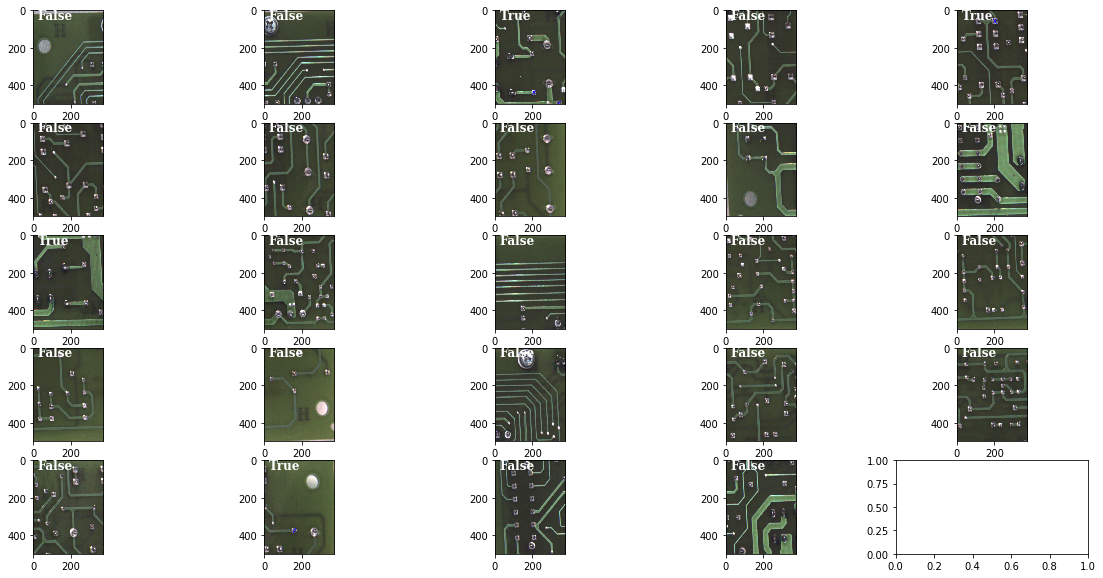

In [153]:
#https://stackoverflow.com/questions/41793931/plotting-images-side-by-side-using-matplotlib
def display(folder):
    
    font = {'family': 'serif',
        'color':  'white',
        'weight': 'bold',
        'size': 12,
        }
    plt.rcParams["figure.figsize"] = (20,10)
    files = glob.glob(folder+"/*"+ext)
    print(len(files))
    small = files
    #small = marked_list
    counter = 0
    f, arr = plt.subplots(5,5)
    for i in range(5):
        for j in range(5):
            img = cv2.imread(small[counter])
            #print(isMarked(img)[1])
            arr[i,j].text(25, 45, str(bool(isMarked(img)[1])), fontdict = font)
            arr[i,j].imshow(img)
            
            counter += 1

display(crop_path_marked)
#print(marked_list[38])
print(len(accept_original))

In [28]:
def data_prep(accepted_list):
    
    
    file = open(data_path+"labels.csv", "w")
    writer = csv.writer(file)
    for a in accepted_list:
        suffix = a[0][len(prefix_marked):]
        a[0] = crop_path_original+"Filtered/"+original_name[:-len(ext)]+"_offset"+suffix
        writer.writerow(a)
    file.close()
data_prep(accept_marked)

COUNT:  0


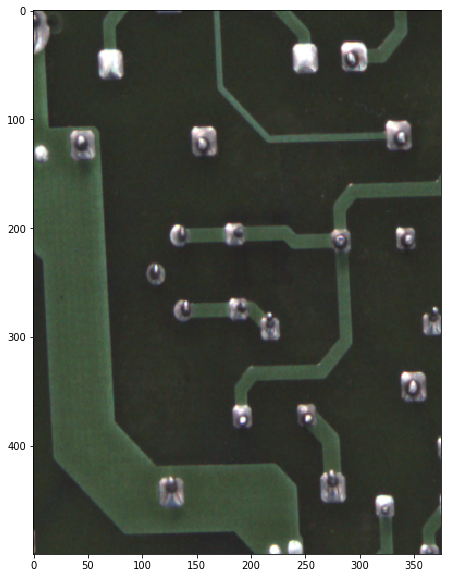

OUTPUT:
ADDITION:


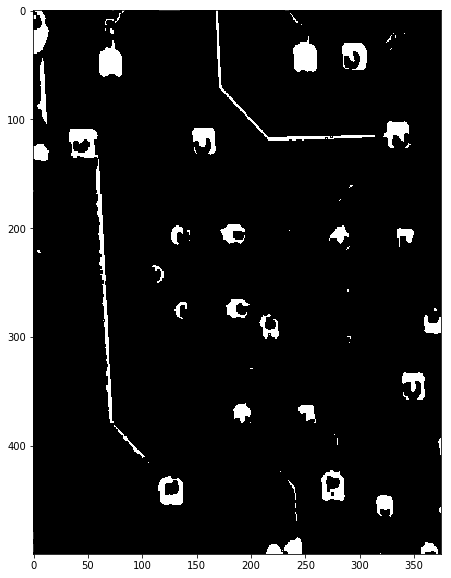

DOTTTT
GREEN:


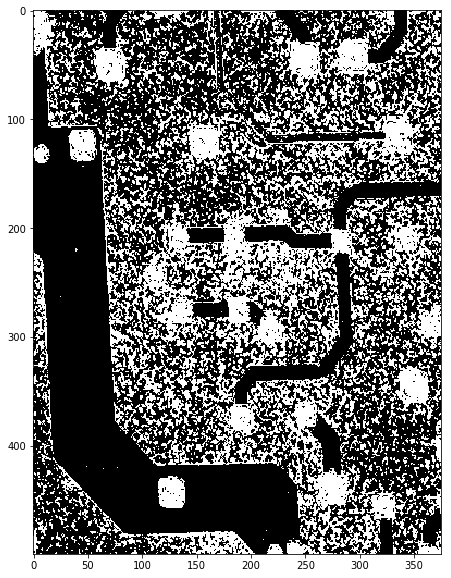

Dot: 


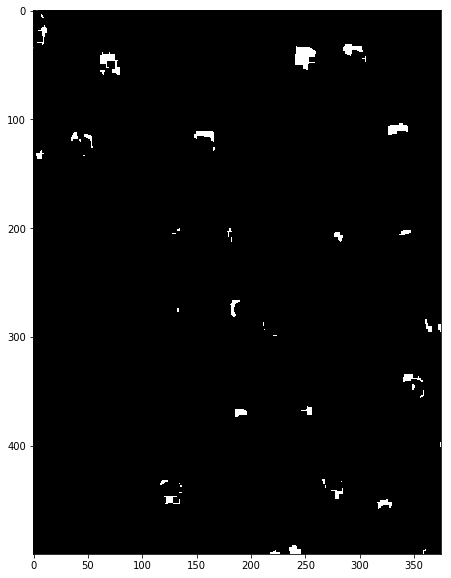

RED MASK: 


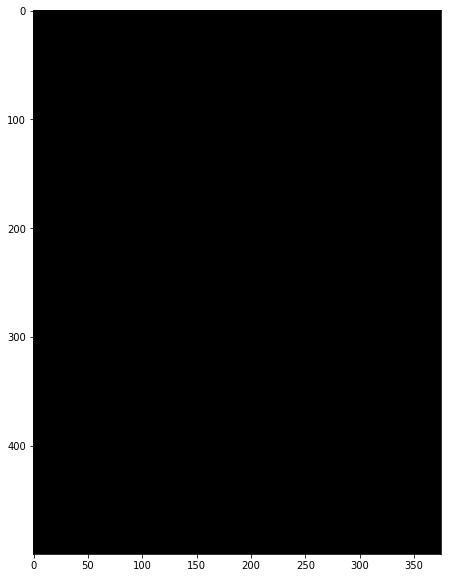

In [258]:
#Single image test
#Convert to black and white using Otsu's algorithm
#Reference: https://stackoverflow.com/questions/7624765/converting-an-opencv-image-to-black-and-white
#The problem with Otsu threshold on sub-image: Takes intensities relatively, might accidentally assign a white color to some random spot in the centre of the image
#Try using thresholding on the entire image and use that threshold value for subimages.
original = cv2.imread(name)
bgr_green = [85,114,80]
green_mask = 255 - detect_color(bgr_green, cv2.cvtColor(original, cv2.COLOR_BGR2HSV), delta=20,min_sat = 10, min_value=10)

red_mask, count = isMarked(original)
print("COUNT: ", count)
####mask = 255 - detect_color(bgr, cv2.cvtColor(original, cv2.COLOR_BGR2HSV))
#original = cv2.GaussianBlur(original,(3,3),0)

gray = cv2.cvtColor(original,cv2.COLOR_BGR2GRAY)

####gray = cv2.cvtColor(original,cv2.COLOR_BGR2GRAY)

plt.imshow(original)
plt.show()

output = cv2.threshold(gray, thresh_first, 255, cv2.THRESH_BINARY)[1]

#Test pixel intensity
#layers = accepted(name)[1]
#PI = pixel_intensities(layers)
#print("PIXEL INTENSITIES : {0}, SUM: {1}".format(PI, sum(PI)))

# ************************************************************** #
# ****************** BLOB DETECTION **************************** #
#blob = cv2.SimpleBlobDetector_create()
#plt.imshow(im)
#plt.show()
#help(type(blob))
#keypoints = blob.detect(im)
#im_with_keypoints = cv2.drawKeypoints(im, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#plt.imshow(im_with_keypoints)
#plt.show()
# ****************** BLOB DETECTION ENDS ************************ #
# *************************************************************** #

###******* RED: Lies on the 0th degree of the Hue angles. Hence, corner cases need to be covered. 0-10 and 150-180, etc
print("OUTPUT:")
#print(output)
print("ADDITION:")
#print(output+red_mask)
dst = remove_noise(output)
dst_mask = remove_noise(green_mask)

dot_prod = np.multiply(dst,dst_mask)*255

plt.imshow(dst,cmap = 'gray')
plt.show()
cv2.imwrite(name+'.bw'+ext, output)
bw = cv2.imread(name+'.bw'+ext,0)

dst_dot = remove_noise(dot_prod)# + red_mask

print("DOTTTT")
#print(dst_dot[:,59])
print("GREEN:")
plt.imshow(green_mask, cmap='gray')
plt.show()

print("Dot: ")
plt.imshow(dst_dot, cmap = 'gray')
plt.show()

print("RED MASK: ")
plt.imshow(red_mask, cmap='gray')
plt.show()

#Enhance contrast of color image
#Reference : https://chrisalbon.com/machine_learning/preprocessing_images/enhance_contrast_of_color_image/
#Reference: https://docs.opencv.org/2.4/doc/tutorials/imgproc/histograms/histogram_equalization/histogram_equalization.html

#Histogram equalization: stretched distribution, 
#i.e. most of the pixel values are concentrated around the average.
#Stretching => make some light pixels lighter and dark pixels darker :. contrast improves
#For color, we convert to YUV cause it helps change intensity without affecting color much
for i in test:
    name = prefix+'0_'+str(i)
    original = cv2.imread(name+ext)
    #Denoising before contrasting - using default values, refer docs
    denoise = cv2.fastNlMeansDenoisingColored(original, None, 2,2,7,21)
    cv2.imwrite(name+'.denoise'+ext, denoise)
    
    #Adds contrast
    #TODO : find a better way, this adds too much contrast
    image_yuv = cv2.cvtColor(denoise, cv2.COLOR_BGR2YUV)
    image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
    image_rgb = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2BGR)
    cv2.imwrite(name+'.contr'+ext, image_rgb)
    

In [104]:
file_path = crop_path_original+"names_"+original_name[:-len(ext)]+".csv"
print(file_path)
fd = open(file_path, "w")
writer = csv.writer(fd)
for a in accept_original:
    writer.writerow([a[0], str(1)])
random.shuffle(unaccept_original)
for u in unaccept_original[:len(accept_original)]:
    writer.writerow([u, str(0)])
fd.close()
print(len(unaccept_original))

/Users/dnyanadajoshi/OneDrive/Ono Project/data/0624/NG_cropped/NG_4/names_NG_4.csv
10415


In [10]:
#Create csv file for image and label. Assign randomly for now to just test the data stream
#Keep a global csv and store entire image path in that, later save all filtered images to a separate global folder
data_parent = '/home/dnyanadajoshi/data/'
file_path = data_parent+"labels-full-"+str(crop_size)+".csv"
flabel = open(file_path, "w")
writer = csv.writer(flabel)
files_ok = sorted(glob.glob(data_parent+"????/OK_cropped/ok_*[0-9]_cropped_"+str(crop_size)+"/*.bmp"))
files_ng = sorted(glob.glob(data_parent+"????/NG_cropped/NG_*[0-9]_cropped_"+str(crop_size)+"/*.bmp"))
files_marked = sorted(glob.glob(data_parent+"????/NG_cropped/NG_*[0-9]_checkmark_cropped_"+str(crop_size)+"/*.bmp"))

#copy ok names
for f in range(len(files_ok)):
    writer.writerow([files_ok[f], str(0)])

#copy ng names
for f in range(len(files_ng)):
    img = cv2.imread(files_marked[f])
    if isMarked(img)[1]:
        writer.writerow([files_ng[f], str(1)])
    else:
        writer.writerow([files_ng[f], str(0)])
flabel.close()

In [862]:
data_parent = '/home/dnyanadajoshi/data/'
sorted(glob.glob(data_parent+"????/NG_cropped/NG_*[0-9]_checkmark/"))

['/home/dnyanadajoshi/data/0624/NG_cropped/NG_1_checkmark/',
 '/home/dnyanadajoshi/data/0624/NG_cropped/NG_2_checkmark/',
 '/home/dnyanadajoshi/data/0624/NG_cropped/NG_3_checkmark/',
 '/home/dnyanadajoshi/data/0624/NG_cropped/NG_4_checkmark/',
 '/home/dnyanadajoshi/data/0702/NG_cropped/NG_1_checkmark/',
 '/home/dnyanadajoshi/data/0719/NG_cropped/NG_10_checkmark/',
 '/home/dnyanadajoshi/data/0719/NG_cropped/NG_5_checkmark/',
 '/home/dnyanadajoshi/data/0719/NG_cropped/NG_7_checkmark/',
 '/home/dnyanadajoshi/data/0719/NG_cropped/NG_8_checkmark/',
 '/home/dnyanadajoshi/data/0719/NG_cropped/NG_9_checkmark/']

In [ ]:
#Remove the test files
for file in glob.glob(os.path.join(crop_path, "*.gray.JPG")):
    os.remove(file)